# Rotinas para a detecção das não-bijetividades

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time
from scipy.optimize import root, root_scalar

In [2]:
def nmse_error(y, y_hat):
    nmse = 10*np.log10(
        np.sum(np.abs(y-y_hat)**2)/
        np.sum(np.abs(y)**2)
        )
    return nmse

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [4]:
def z2n(n):
    return n if n<0 else None

In [5]:
def prep_data_y(y, M, My=1):
    a0 = np.abs(y)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(My-1):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T
    return abs

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    abs = []
    size = x.shape[0]-M
    for m in range(1,size):
        abs.append(a0[m:m+M+1])
    abs = np.array(abs)

    p0 = np.angle(x)
    phase = []
    for m in range(1,size):
        phase.append(p0[m:m+M+1])
    phase = np.array(phase)
    
    delta = []
    for m in range(1,phase.shape[1]):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)
    return abs, d_cos, d_sin

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [22]:
def gerar_s(y, x, M=0):
    s = y*np.exp(-1j*np.angle(x))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name, activation='tanh'):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    return model

In [88]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'])

In [95]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=3000, verbose=0)
    return history

In [96]:
def validation_models(model_real, model_imag, inputs, x, y):
    s_hat_real = model_real.predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model_imag.predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x)
    # nmse
    nmse = nmse_error(y, y_hat)
    return nmse

In [97]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    best_y_hat = None
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
        a,dc,ds = prep_data(x, M)
        inputs = np.concatenate([a,dc,ds], axis=1)
        s_real, s_imag = gerar_s(y,x,M)

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)
        his = [0,0]
        his[0] = fit_model(model_real, 3000, inputs, s_real)
        his[1] = fit_model(model_imag, 3000, inputs, s_imag)
        
        model = (model_real, model_imag)
        y = y[M+1:]
        x = x[M+1:]
        # nmse = validation_models(model_real, model_imag, inputs, x, y)
        nmse, y_hat = validation(model, x, y, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model
            best_M = M
            best_y_hat = y_hat
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M, best_y_hat, best_nmse, his

In [98]:
def run_model(x, model, M):
    a,dc,ds = prep_data(x, M)    
    inputs = np.concatenate([a,dc,ds], axis=1)
    
    s_hat_real = model[0].predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model[1].predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M+1:])
    return y_hat

In [99]:
def validation(model, x, y, M):
    y_hat = run_model(x, model, M)
    nmse = nmse_error(y[M+1:], y_hat)
    return nmse, y_hat

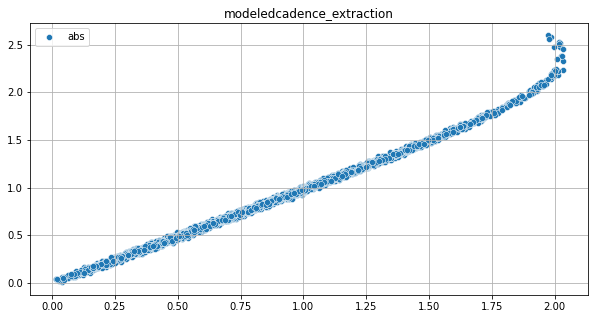

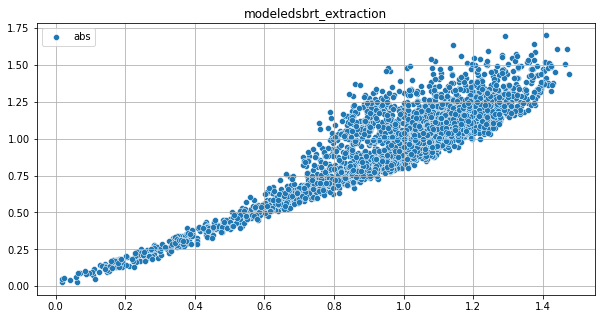

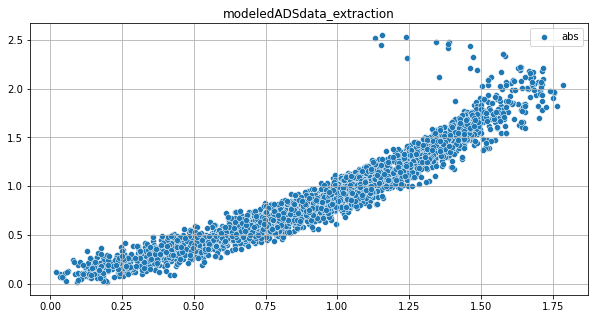

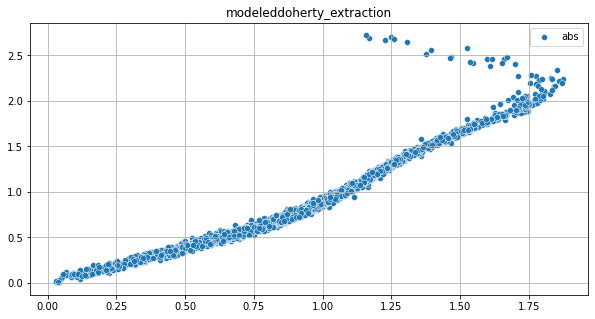

In [17]:
# plot inversa PA
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    # best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    '''
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)
    '''

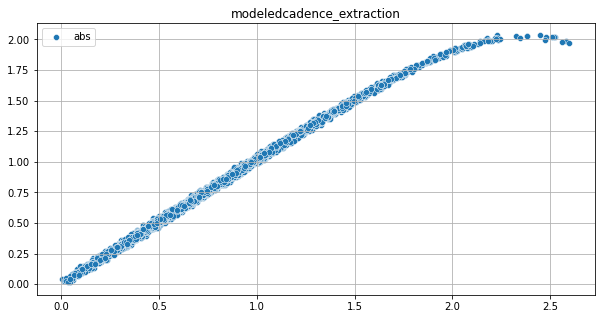

*** BEST ***
Shape:10 M:3 HL:7 nmse:-28.477542400360107 time:443.7636778354645
nmse - extraction: -28.477542400360107
nmse - validation: -27.526977062225342


In [102]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

model, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=3, M_max=3, HL_min=7, HL_max=7)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, _ = validation(model, x, y, M)
print(f'nmse - validation: {nmse}')

In [108]:
model[0].load_weights('./models/modeledcadence_extraction_weights_real');
model[1].load_weights('./models/modeledcadence_extraction_weights_imag');

nmse - extraction: -53.554439544677734


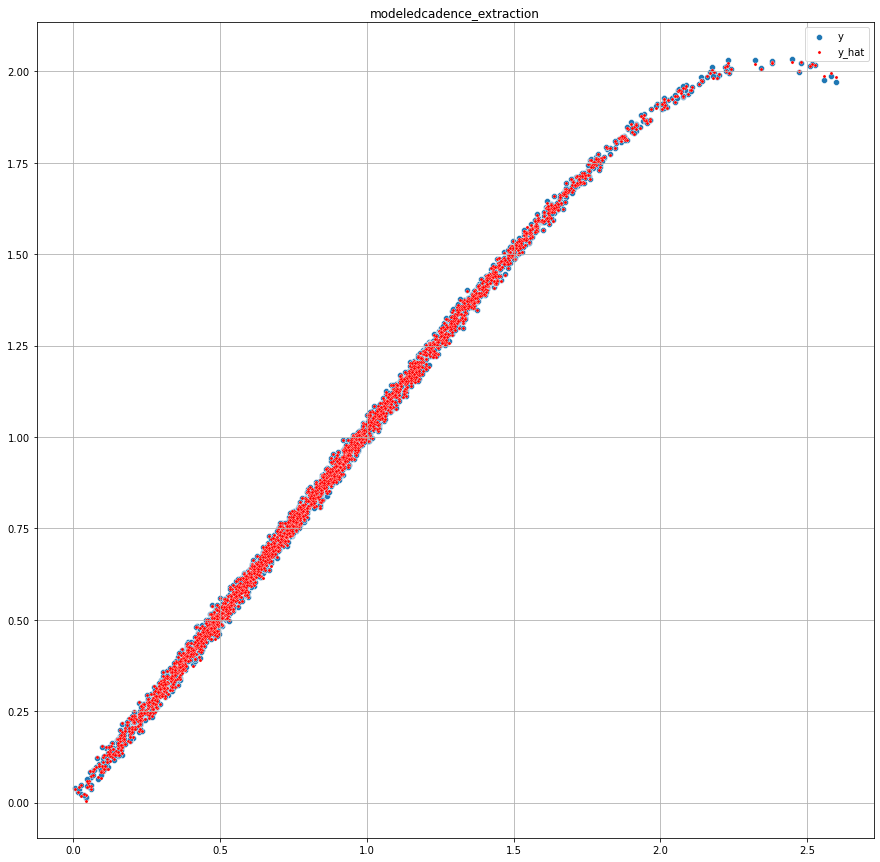

In [111]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)
M = 3
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(15,15))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

In [53]:
from functools import partial

In [566]:
def inverse_problem(x, y, model, M, x_old, exp=False):
    if exp:
        x = np.array([x[0]*np.exp(1j*x[1])])
    else:
        x = np.array([x[0]+1j*x[1]])
    
    if np.abs(x) > 3:
        gama = np.abs(x)
    else:
        gama = 1
    x = np.concatenate([x_old, x])

    y_hat = run_model(x, model, M)

    y_real, y_imag = y_hat.real, y_hat.imag
    output = np.array([y.real - y_real, y.imag - y_imag]).reshape(-1,)
    output *= gama
    return output

In [588]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([-2.0,2.0]) # Chute inicial de x0
x02 = np.array([2.0,-2.0]) # Chute inicial de x0
x03 = np.array([-0.5,0.5]) # Chute inicial de x0
x04 = np.array([0.5,-0.5]) # Chute inicial de x0
xs = [x01, x02, x03, x04]

for n, x_n in enumerate(x):
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a} -> {np.abs(x_a)}')
    for i, x0 in enumerate(xs):
        x0 = (x0[0]+1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]+1j*res[i].x[1]).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
    print()

inicia o problema inverso nº 221
x:   [0.5700263+1.9241145j] -> [2.0067751]
x00: [-2.+2.j] -> [0.45413114+2.79110651j] -> [2.82781022] -> -130.4776395056124 -> -7.212752950746308
x01: [2.-2.j] -> [0.45412888+2.7911095j] -> [2.82781281] -> -140.8418854236087 -> -7.212720559643588
x02: [-0.5+0.5j] -> [0.57002627+1.92411433j] -> [2.006775] -> -144.15723442758497 -> -143.1039445194431
x03: [0.5-0.5j] -> [0.45412885+2.79110869j] -> [2.82781201] -> -142.06744500971035 -> -7.21272851609773

inicia o problema inverso nº 222
x:   [0.53862906+2.1023464j] -> [2.1702492]
x00: [-2.+2.j] -> [0.53863022+2.10234703j] -> [2.17025011] -> -145.3780632070471 -> -124.33447528888367
x01: [2.-2.j] -> [2.72190748-0.28634591j] -> [2.73692789] -> -4.526130092392009 -> 3.4703343938905666
x02: [-0.5+0.5j] -> [0.50006589+2.58888875j] -> [2.63674247] -> -133.74860810660462 -> -12.960582280568715
x03: [0.5-0.5j] -> [0.53862964+2.10234716j] -> [2.1702501] -> -144.44900048083258 -> -127.237451999046

inicia o problema

In [ ]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([-2.0,2.0]) # Chute inicial de x0
x02 = np.array([2.0,-2.0]) # Chute inicial de x0
x03 = np.array([-0.5,0.5]) # Chute inicial de x0
x04 = np.array([0.5,-0.5]) # Chute inicial de x0
xs = [x01, x02, x03, x04]

for n, x_n in enumerate(x):
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a} -> {np.abs(x_a)}')
    for i, x0 in enumerate(xs):
        x0 = (x0[0]+1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]+1j*res[i].x[1]).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
    print()

inicia o problema inverso nº 221
x:   [0.5700263+1.9241145j] -> [2.0067751]
x00: [-2.+2.j] -> [0.45413114+2.79110651j] -> [2.82781022] -> -130.4776395056124 -> -7.212752950746308
x01: [2.-2.j] -> [0.45412888+2.7911095j] -> [2.82781281] -> -140.8418854236087 -> -7.212720559643588
x02: [-0.5+0.5j] -> [0.57002627+1.92411433j] -> [2.006775] -> -144.15723442758497 -> -143.1039445194431
x03: [0.5-0.5j] -> [0.45412885+2.79110869j] -> [2.82781201] -> -142.06744500971035 -> -7.21272851609773

inicia o problema inverso nº 222
x:   [0.53862906+2.1023464j] -> [2.1702492]
x00: [-2.+2.j] -> [0.53863022+2.10234703j] -> [2.17025011] -> -145.3780632070471 -> -124.33447528888367
x01: [2.-2.j] -> [2.72190748-0.28634591j] -> [2.73692789] -> -4.526130092392009 -> 3.4703343938905666
x02: [-0.5+0.5j] -> [0.50006589+2.58888875j] -> [2.63674247] -> -133.74860810660462 -> -12.960582280568715
x03: [0.5-0.5j] -> [0.53862964+2.10234716j] -> [2.1702501] -> -144.44900048083258 -> -127.237451999046

inicia o problema

In [590]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([0.5,-np.pi/2]) # Chute inicial de x0
x02 = np.array([2,-np.pi/2]) # Chute inicial de x0
x03 = np.array([0.5, np.pi/2]) # Chute inicial de x0
x04 = np.array([2, np.pi/2]) # Chute inicial de x0
xs = [x01, x02, x03, x04]

for n, x_n in enumerate(x):
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old, exp=True)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a}')
    for i, x0 in enumerate(xs):
        x0 = x0[0]*np.exp(1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]*np.exp(1j*res[i].x[1])).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')

    print()

inicia o problema inverso nº 221
x:   [0.5700263+1.9241145j]
x00: [3.061617e-17-0.5j] -> [0.00077106-0.00142956j] -> [0.00162424] -> -4.788361700421447 -> 0.004984764525276674
x01: [1.2246468e-16-2.j] -> [0.45413165+2.79110633j] -> [2.82781012] -> -131.58360836261946 -> -7.212755456314306
x02: [3.061617e-17+0.5j] -> [0.57002542+1.92411396j] -> [2.0067744] -> -137.2166665962634 -> -126.09390744579878
x03: [1.2246468e-16+2.j] -> [0.57002719+1.92411458j] -> [2.0067755] -> -136.39102144986316 -> -126.76746085678786

inicia o problema inverso nº 222
x:   [0.53862906+2.1023464j]
x00: [3.061617e-17-0.5j] -> [0.50006709+2.58888756j] -> [2.63674153] -> -139.57883622424575 -> -12.96060511580378
x01: [1.2246468e-16-2.j] -> [0.53863035+2.10234836j] -> [2.17025143] -> -136.96779510258023 -> -119.38366096694104
x02: [3.061617e-17+0.5j] -> [0.53863035+2.10234838j] -> [2.17025145] -> -136.97450388740359 -> -119.33618335244117
x03: [1.2246468e-16+2.j] -> [0.53863049+2.10234858j] -> [2.17025168] -> -150

- Treinar uma rede neural sem memória para ver a continuidade da função
- Testar o treinamento da inversa da rede para um modelo com ou sem inversa
- Entender melhor a influência do chute inicial no resultado

Validação - nmse:-41.43819808959961


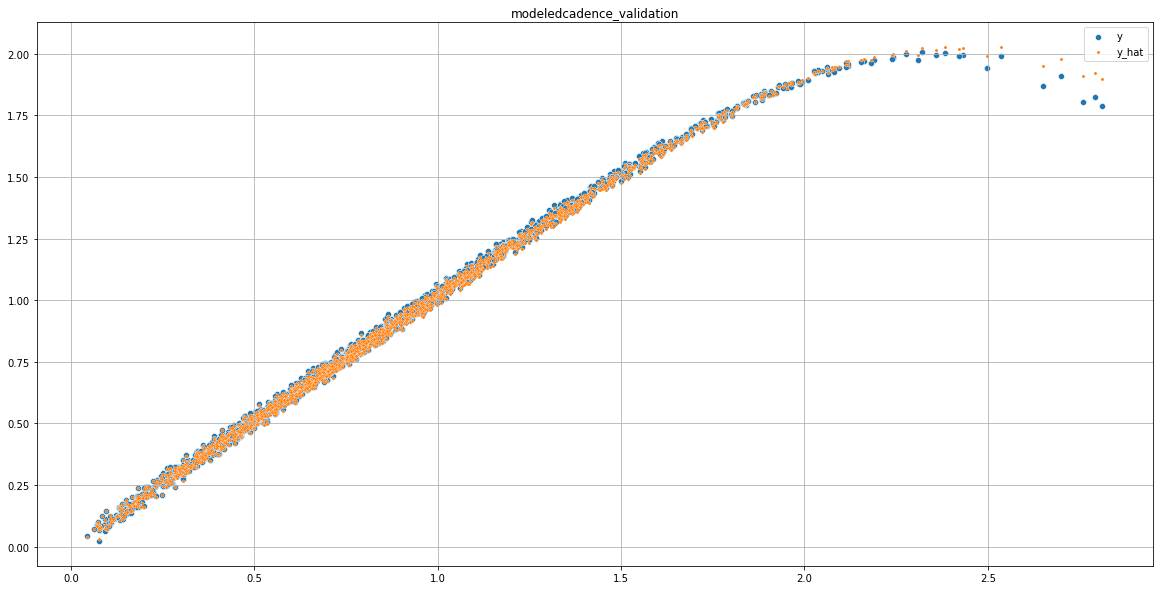

In [469]:
p = Path('../data/modeledcadence_validation.csv')
data = load_csv2numpy(p)
M = 3
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs[M+1:], y=y_abs[M+1:], label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10)
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()